In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_zones/freyberg_zn/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY M

run pestpp

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 10
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_zn.pst


In [4]:
pst.phi

409.23533731094983

In [5]:
pst.phi_components

{'calflux': 0.0007629895582580566,
 'calhead': 409.23457432139156,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [6]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
flx_river_l_19700102,flx_river_l_19700102,calflux,-3706.027000,-3706.303223,0.276223,0.1
cr03c10_19700102,cr03c10_19700102,calhead,22.331451,22.807440,-0.475989,5.0
cr03c16_19700102,cr03c16_19700102,calhead,18.526869,19.804741,-1.277872,5.0
cr04c09_19700102,cr04c09_19700102,calhead,24.412637,23.432306,0.980331,5.0
cr10c02_19700102,cr10c02_19700102,calhead,27.985834,28.026882,-0.041048,5.0
cr14c11_19700102,cr14c11_19700102,calhead,21.070509,19.088724,1.981784,5.0
cr16c17_19700102,cr16c17_19700102,calhead,15.468176,17.337614,-1.869438,5.0
cr22c11_19700102,cr22c11_19700102,calhead,20.485881,20.909229,-0.423348,5.0
cr23c16_19700102,cr23c16_19700102,calhead,15.308345,15.917829,-0.609483,5.0


(11.326556562029246, 28.786360092970749)

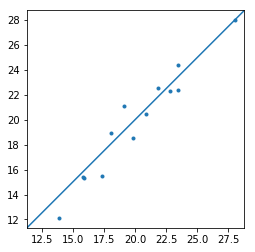

In [7]:
ax = plt.subplot(111,aspect="equal") 
wl_names = [n for n in pst.nnz_obs_names if n.startswith("c")]
ax.scatter(pst.res.loc[wl_names,"modelled"],pst.res.loc[wl_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

In [8]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.055462,-0.110924,0.110924,0.017354,0.008089,0.001177,0.033532
RCH_1,0.00000,0.055462,-0.110924,0.110924,0.000000,0.055462,-0.110924,0.110924
HK_Z01,0.69897,0.500000,-0.301030,1.698970,1.698970,0.499963,0.699045,2.698900
HK_Z02,0.69897,0.500000,-0.301030,1.698970,0.972522,0.291445,0.389632,1.555410
HK_Z03,0.69897,0.500000,-0.301030,1.698970,0.965894,0.156054,0.653787,1.278000
HK_Z04,0.69897,0.500000,-0.301030,1.698970,0.978248,0.313881,0.350485,1.606010
HK_Z05,0.69897,0.500000,-0.301030,1.698970,-0.138162,0.283996,-0.706155,0.429830
HK_Z06,0.69897,0.500000,-0.301030,1.698970,1.473250,0.187878,1.097490,1.849000


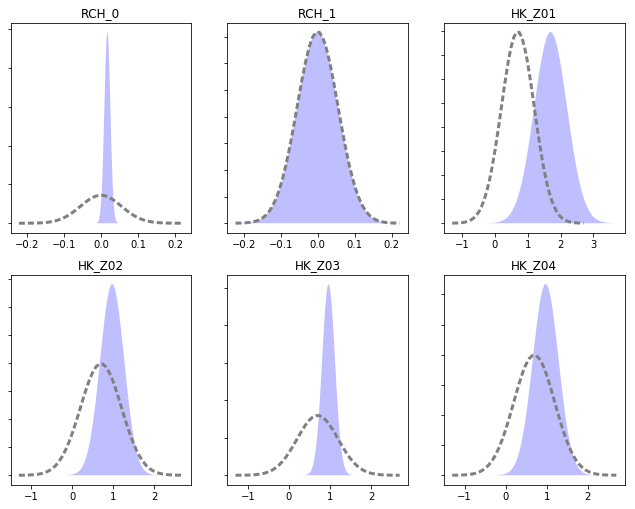

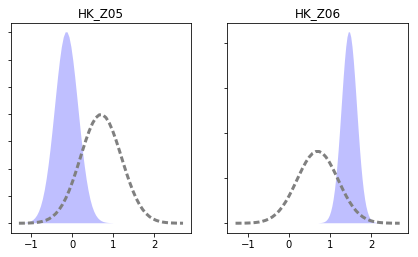

In [9]:
axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)

Why is ``rch_1`` unaffected by calibration?

In [ ]:
df_predu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)

In [ ]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"k--")
    ax.set_ylim(ylim)

Now we have some variability in the forecast outcomes...why?

As far as the "truth" is concerned, we are doing better for most forecasts.  But we are especially bad for the tranvel time forecast - why?  What affects travel time?